
# ***Plant Disease Classification - DenseNet169***

> Before going forward with modelling we need to split the data into train, test and validation to make it easy for modelling.
For that we first install spilt_folders and then use it to split the input data in following ratio 80:10:10.

In [ ]:
!pip install split_folders

In [ ]:
import splitfolders
import os

os.makedirs('output')
os.makedirs('output/train')
os.makedirs('output/val')
os.makedirs('output/test')

loc = "../input/plantvillage-dataset/color"

splitfolders.ratio(loc,output = "output",seed = 42,ratio = (0.80,.1,.1))

Copying files: 54305 files [06:09, 146.94 files/s]


> We are only going to make use of the color images so no need split grayscale and segmented images.

In [ ]:
import os

for dirpath,dirname,filename in os.walk("./output"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

There are 3 directories and 0 images in './output'.
There are 38 directories and 0 images in './output/test'.
There are 0 directories and 101 images in './output/test/Pepper,_bell___Bacterial_spot'.
There are 0 directories and 100 images in './output/test/Potato___Late_blight'.
There are 0 directories and 52 images in './output/test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'.
There are 0 directories and 28 images in './output/test/Apple___Cedar_apple_rust'.
There are 0 directories and 169 images in './output/test/Tomato___Spider_mites Two-spotted_spider_mite'.
There are 0 directories and 63 images in './output/test/Apple___Black_rot'.
There are 0 directories and 509 images in './output/test/Soybean___healthy'.
There are 0 directories and 184 images in './output/test/Squash___Powdery_mildew'.
There are 0 directories and 16 images in './output/test/Potato___healthy'.
There are 0 directories and 117 images in './output/test/Corn_(maize)___healthy'.
There are 0 directories and 47 

> After modifying our input data and before the start of modelling its always best to visualize some random images of the dataset

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random

def plot_random_image(target_dir,target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder),1)
    img = mping.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

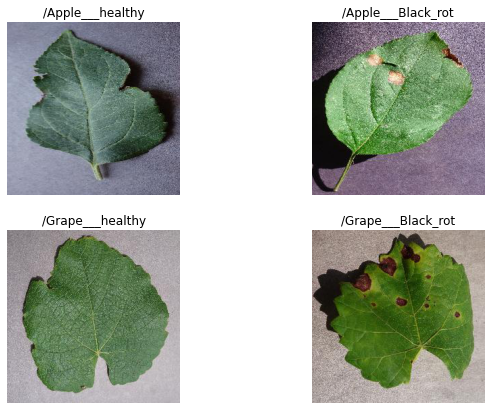

In [ ]:
fig = plt.figure(figsize = (10,7))
fig.add_subplot(2,2,1)
img_1 = plot_random_image(target_dir = "./output/train",target_class = "/Apple___healthy")
fig.add_subplot(2,2,2)
img_2 = plot_random_image(target_dir = "./output/train",target_class = "/Apple___Black_rot")
fig.add_subplot(2,2,3)
img_3 = plot_random_image(target_dir = "./output/train",target_class = "/Grape___healthy")
fig.add_subplot(2,2,4)
img_4 = plot_random_image(target_dir = "./output/train",target_class = "/Grape___Black_rot")

# GETTING OUR DATA AND CALLBACKS READY

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

> When we use mixed_precision training the computation speed is increased by 3x times based on the GPU available. Mixed precision enables training using float16 half-precision variables whenever possible.

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "./output/train"
val_dir = "./output/val"
test_dir  = "./output/test"


train_data = image_dataset_from_directory(train_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 42,shuffle = True)


val_data = image_dataset_from_directory(val_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 42,shuffle = False)


test_data = image_dataset_from_directory(test_dir,label_mode="categorical",image_size = (224,224),
                                          batch_size = 32,seed = 42,shuffle = False)

Found 43429 files belonging to 38 classes.
Found 5417 files belonging to 38 classes.
Found 5459 files belonging to 38 classes.


In [ ]:
print(train_data)
print(test_data)
print(val_data)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 38)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 38)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 38)), types: (tf.float32, tf.float32)>


In [ ]:
class_names = train_data.class_names
print(len(class_names))
print(class_names)

38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target

In [ ]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 5,min_delta = 0.0001,restore_best_weights = True,verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",paitence = 4,factor = 0.5,patience = 4,min_lr = 1e-7,verbose = 1)

> * Earlystopping callback stops training when the model stops improving in terms of validation loss(in this case) and prevents overfitting.
> * ReduceLROnPlateau reduces the learning rate by 5x(in this case) whenever validation loss is not improving.
> * With the combination of Earlystopping and ReduceLROnPlateau callback when can train our model for any number of epochs without worrying about overfitting.

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Feature Extractor DenseNet169

In [ ]:
base_model = tf.keras.applications.DenseNet169(include_top = False)
base_model.trainable = False

51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
for layer_num,layer in enumerate(base_model.layers):
  print(layer_num,layer.name,layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
data_aug = tf.keras.Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.Rescaling(1/255.)
],name = "data_augmentation_layer")

> Data augmentation is used here to prevent overfitting, we can experiment without data augmentation and check whether the model overfits or not,but since we are using a transfer learning Architecture such as DenseNet,its best to include data augmentation since the probability of our model overfitting is very high.

In [ ]:
inputs = layers.Input(shape = (224,224,3),name = "Input_layer")
x = data_aug(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x)
x = layers.Dense(32,activation = "relu",kernel_initializer = tf.keras.initializers.HeNormal(),name = "Dense_layer_1")(x)
x = layers.Dense(38,name = "Dense_layer_2")(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
model_1 = tf.keras.Model(inputs,outputs)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
densenet169 (Functional)     (None, None, None, 1664)  12642880  
_________________________________________________________________
Global_average_pooling_layer (None, 1664)              0         
_________________________________________________________________
Dense_layer_1 (Dense)        (None, 32)                53280     
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 38)                1254      
_________________________________________________________________
activation (Activation)      (None, 38)                0     

In [ ]:
for layer_num,layer in enumerate(model_1.layers):
  print(layer_num,layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

0 Input_layer True float32 <Policy "float32">
1 data_augmentation_layer True float32 <Policy "mixed_float16">
2 densenet169 False float32 <Policy "mixed_float16">
3 Global_average_pooling_layer True float32 <Policy "mixed_float16">
4 Dense_layer_1 True float32 <Policy "mixed_float16">
5 Dense_layer_2 True float32 <Policy "mixed_float16">
6 activation True float32 <Policy "float32">


In [ ]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
history_1 = model_1.fit(train_data,epochs = 40,steps_per_epoch=len(train_data),
                        validation_data = val_data,validation_steps = int(0.25*len(val_data)),
                        callbacks = [early_stop,reduce_lr])

Epoch 1/40
 343/1358 [======>.......................] - ETA: 1:48 - loss: 1.7766 - accuracy: 0.5568

Cleanup called...


1358/1358 [==============================] - 155s 101ms/step - loss: 0.8905 - accuracy: 0.7668 - val_loss: 0.3343 - val_accuracy: 0.8973
Epoch 2/40
 343/1358 [======>.......................] - ETA: 1:29 - loss: 0.3809 - accuracy: 0.8878

Cleanup called...


1358/1358 [==============================] - 121s 89ms/step - loss: 0.3301 - accuracy: 0.9003 - val_loss: 0.1904 - val_accuracy: 0.9472
Epoch 3/40
 343/1358 [======>.......................] - ETA: 1:25 - loss: 0.2766 - accuracy: 0.9108

Cleanup called...


1358/1358 [==============================] - 117s 86ms/step - loss: 0.2562 - accuracy: 0.9196 - val_loss: 0.1550 - val_accuracy: 0.9509
Epoch 4/40
 343/1358 [======>.......................] - ETA: 1:23 - loss: 0.2274 - accuracy: 0.9231

Cleanup called...


1358/1358 [==============================] - 114s 84ms/step - loss: 0.2185 - accuracy: 0.9285 - val_loss: 0.1538 - val_accuracy: 0.9501
Epoch 5/40
 343/1358 [======>.......................] - ETA: 1:22 - loss: 0.1952 - accuracy: 0.9368

Cleanup called...


1358/1358 [==============================] - 112s 83ms/step - loss: 0.1969 - accuracy: 0.9351 - val_loss: 0.1440 - val_accuracy: 0.9494
Epoch 6/40
 343/1358 [======>.......................] - ETA: 1:21 - loss: 0.1849 - accuracy: 0.9391

Cleanup called...


1358/1358 [==============================] - 112s 82ms/step - loss: 0.1796 - accuracy: 0.9407 - val_loss: 0.1847 - val_accuracy: 0.9412
Epoch 7/40
 344/1358 [======>.......................] - ETA: 1:20 - loss: 0.1753 - accuracy: 0.9427

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.1716 - accuracy: 0.9427 - val_loss: 0.1168 - val_accuracy: 0.9613
Epoch 8/40
 344/1358 [======>.......................] - ETA: 1:18 - loss: 0.1681 - accuracy: 0.9417

Cleanup called...


1358/1358 [==============================] - 108s 79ms/step - loss: 0.1628 - accuracy: 0.9455 - val_loss: 0.1382 - val_accuracy: 0.9516
Epoch 9/40
 343/1358 [======>.......................] - ETA: 1:18 - loss: 0.1601 - accuracy: 0.9464

Cleanup called...


1358/1358 [==============================] - 108s 79ms/step - loss: 0.1560 - accuracy: 0.9480 - val_loss: 0.1252 - val_accuracy: 0.9621
Epoch 10/40
 343/1358 [======>.......................] - ETA: 1:18 - loss: 0.1473 - accuracy: 0.9479

Cleanup called...


1358/1358 [==============================] - 107s 78ms/step - loss: 0.1487 - accuracy: 0.9496 - val_loss: 0.1293 - val_accuracy: 0.9531
Epoch 11/40
 343/1358 [======>.......................] - ETA: 1:18 - loss: 0.1437 - accuracy: 0.9531

Cleanup called...


1358/1358 [==============================] - 106s 78ms/step - loss: 0.1456 - accuracy: 0.9517 - val_loss: 0.1394 - val_accuracy: 0.9509

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 12/40
 343/1358 [======>.......................] - ETA: 1:15 - loss: 0.1328 - accuracy: 0.9559

Cleanup called...


1358/1358 [==============================] - 105s 77ms/step - loss: 0.1274 - accuracy: 0.9571 - val_loss: 0.1014 - val_accuracy: 0.9628
Epoch 13/40
 343/1358 [======>.......................] - ETA: 1:15 - loss: 0.1335 - accuracy: 0.9559

Cleanup called...


1358/1358 [==============================] - 105s 77ms/step - loss: 0.1259 - accuracy: 0.9580 - val_loss: 0.1005 - val_accuracy: 0.9658
Epoch 14/40
 344/1358 [======>.......................] - ETA: 1:15 - loss: 0.1241 - accuracy: 0.9594

Cleanup called...


1358/1358 [==============================] - 104s 77ms/step - loss: 0.1245 - accuracy: 0.9592 - val_loss: 0.0888 - val_accuracy: 0.9680
Epoch 15/40
 344/1358 [======>.......................] - ETA: 1:15 - loss: 0.1262 - accuracy: 0.9571

Cleanup called...


1358/1358 [==============================] - 104s 76ms/step - loss: 0.1238 - accuracy: 0.9595 - val_loss: 0.0899 - val_accuracy: 0.9702
Epoch 16/40
 344/1358 [======>.......................] - ETA: 1:15 - loss: 0.1190 - accuracy: 0.9607

Cleanup called...


1358/1358 [==============================] - 104s 76ms/step - loss: 0.1179 - accuracy: 0.9603 - val_loss: 0.0882 - val_accuracy: 0.9695
Epoch 17/40
 343/1358 [======>.......................] - ETA: 1:15 - loss: 0.1190 - accuracy: 0.9605

Cleanup called...


1358/1358 [==============================] - 104s 76ms/step - loss: 0.1208 - accuracy: 0.9603 - val_loss: 0.1141 - val_accuracy: 0.9643
Epoch 18/40
 343/1358 [======>.......................] - ETA: 1:15 - loss: 0.1241 - accuracy: 0.9590

Cleanup called...


1358/1358 [==============================] - 104s 77ms/step - loss: 0.1169 - accuracy: 0.9606 - val_loss: 0.0893 - val_accuracy: 0.9680
Epoch 19/40
 343/1358 [======>.......................] - ETA: 1:14 - loss: 0.1174 - accuracy: 0.9595

Cleanup called...


1358/1358 [==============================] - 103s 75ms/step - loss: 0.1169 - accuracy: 0.9616 - val_loss: 0.1131 - val_accuracy: 0.9643
Epoch 20/40
 343/1358 [======>.......................] - ETA: 1:14 - loss: 0.1133 - accuracy: 0.9630

Cleanup called...


1358/1358 [==============================] - 103s 76ms/step - loss: 0.1124 - accuracy: 0.9621 - val_loss: 0.0969 - val_accuracy: 0.9673

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 21/40
 344/1358 [======>.......................] - ETA: 1:13 - loss: 0.1045 - accuracy: 0.9661

Cleanup called...


1358/1358 [==============================] - 102s 75ms/step - loss: 0.1023 - accuracy: 0.9663 - val_loss: 0.0882 - val_accuracy: 0.9710
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


In [ ]:
print("Validation Accuracy = ",model_1.evaluate(val_data))
print("Testing Accuracy is = ",model_1.evaluate(test_data))

170/170 [==============================] - 12s 68ms/step - loss: 0.1568 - accuracy: 0.9487
Validation Accuracy =  [0.15677522122859955, 0.9486801028251648]
171/171 [==============================] - 12s 67ms/step - loss: 0.1450 - accuracy: 0.9505
Testing Accuracy is =  [0.14503173530101776, 0.9505403637886047]


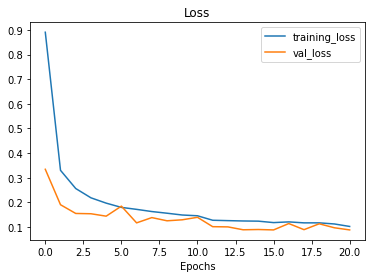

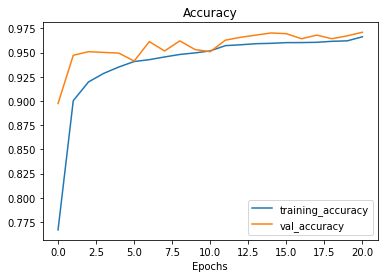

In [ ]:
plot_loss_curves(history_1)

> * Training Accuracy - 95.96%
> * Testing Accuracy  - 95.16%
> * Validation Accuracy - 95.44%

> Feature Extractor DenseNet169 itself is performing extremely well on both train and test data without overfitting. Now let us fine tune our model to improve its performance even further

# Fine Tuned DenseNet169

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False

> Now in order to improve our model's performance we unfreeze the top 30 layers closer to the output layer and let them train on our data instead of using pre-trained weights.

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [ ]:
for layer_num,layer in enumerate(model_1.layers):
  print(layer_num,layer.name,layer.trainable)

0 Input_layer True
1 data_augmentation_layer True
2 densenet169 True
3 Global_average_pooling_layer True
4 Dense_layer_1 True
5 Dense_layer_2 True
6 activation True


In [ ]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(1e-4),
                metrics = ["accuracy"])

In [ ]:
history_2 = model_1.fit(train_data,epochs = 60,initial_epoch = history_1.epoch[-1],steps_per_epoch=len(train_data),
                        validation_data = val_data,validation_steps = int(0.25*len(val_data)),
                        callbacks = [early_stop,reduce_lr])

Epoch 21/60
 343/1358 [======>.......................] - ETA: 1:21 - loss: 0.3424 - accuracy: 0.9083

Cleanup called...


1358/1358 [==============================] - 126s 84ms/step - loss: 0.2191 - accuracy: 0.9368 - val_loss: 0.1114 - val_accuracy: 0.9658
Epoch 22/60
 343/1358 [======>.......................] - ETA: 1:20 - loss: 0.1427 - accuracy: 0.9567

Cleanup called...


1358/1358 [==============================] - 111s 82ms/step - loss: 0.1365 - accuracy: 0.9576 - val_loss: 0.0957 - val_accuracy: 0.9717
Epoch 23/60
 343/1358 [======>.......................] - ETA: 1:20 - loss: 0.1189 - accuracy: 0.9622

Cleanup called...


1358/1358 [==============================] - 112s 82ms/step - loss: 0.1097 - accuracy: 0.9645 - val_loss: 0.0676 - val_accuracy: 0.9799
Epoch 24/60
 343/1358 [======>.......................] - ETA: 1:20 - loss: 0.0915 - accuracy: 0.9696

Cleanup called...


1358/1358 [==============================] - 111s 81ms/step - loss: 0.0948 - accuracy: 0.9694 - val_loss: 0.0685 - val_accuracy: 0.9821
Epoch 25/60
 343/1358 [======>.......................] - ETA: 1:21 - loss: 0.0842 - accuracy: 0.9728

Cleanup called...


1358/1358 [==============================] - 111s 82ms/step - loss: 0.0831 - accuracy: 0.9725 - val_loss: 0.0703 - val_accuracy: 0.9821
Epoch 26/60
 343/1358 [======>.......................] - ETA: 1:21 - loss: 0.0748 - accuracy: 0.9750

Cleanup called...


1358/1358 [==============================] - 111s 82ms/step - loss: 0.0711 - accuracy: 0.9769 - val_loss: 0.0697 - val_accuracy: 0.9807
Epoch 27/60
 343/1358 [======>.......................] - ETA: 1:21 - loss: 0.0785 - accuracy: 0.9742

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0678 - accuracy: 0.9775 - val_loss: 0.0593 - val_accuracy: 0.9829
Epoch 28/60
 343/1358 [======>.......................] - ETA: 1:20 - loss: 0.0592 - accuracy: 0.9813

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0609 - accuracy: 0.9800 - val_loss: 0.0686 - val_accuracy: 0.9799
Epoch 29/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0553 - accuracy: 0.9806

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0576 - accuracy: 0.9807 - val_loss: 0.0600 - val_accuracy: 0.9836
Epoch 30/60
 343/1358 [======>.......................] - ETA: 1:20 - loss: 0.0479 - accuracy: 0.9835

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0479 - accuracy: 0.9838 - val_loss: 0.0552 - val_accuracy: 0.9836
Epoch 31/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0484 - accuracy: 0.9837

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0462 - accuracy: 0.9844 - val_loss: 0.0531 - val_accuracy: 0.9851
Epoch 32/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0401 - accuracy: 0.9865

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0430 - accuracy: 0.9857 - val_loss: 0.0477 - val_accuracy: 0.9836
Epoch 33/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0424 - accuracy: 0.9859

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0428 - accuracy: 0.9855 - val_loss: 0.0406 - val_accuracy: 0.9874
Epoch 34/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0403 - accuracy: 0.9872

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0379 - accuracy: 0.9871 - val_loss: 0.0502 - val_accuracy: 0.9881
Epoch 35/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0319 - accuracy: 0.9899

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0370 - accuracy: 0.9880 - val_loss: 0.0433 - val_accuracy: 0.9881
Epoch 36/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0322 - accuracy: 0.9893

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0329 - accuracy: 0.9885 - val_loss: 0.0354 - val_accuracy: 0.9874
Epoch 37/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0378 - accuracy: 0.9885

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0334 - accuracy: 0.9885 - val_loss: 0.0592 - val_accuracy: 0.9836
Epoch 38/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0305 - accuracy: 0.9897

Cleanup called...


1358/1358 [==============================] - 110s 81ms/step - loss: 0.0277 - accuracy: 0.9902 - val_loss: 0.0510 - val_accuracy: 0.9881
Epoch 39/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0257 - accuracy: 0.9906

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0279 - accuracy: 0.9903 - val_loss: 0.0449 - val_accuracy: 0.9874
Epoch 40/60
 343/1358 [======>.......................] - ETA: 1:18 - loss: 0.0291 - accuracy: 0.9903

Cleanup called...


1358/1358 [==============================] - 108s 80ms/step - loss: 0.0265 - accuracy: 0.9910 - val_loss: 0.0442 - val_accuracy: 0.9874

Epoch 00040: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 41/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0212 - accuracy: 0.9931

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0209 - accuracy: 0.9929 - val_loss: 0.0352 - val_accuracy: 0.9896
Epoch 42/60
 344/1358 [======>.......................] - ETA: 1:19 - loss: 0.0231 - accuracy: 0.9924

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0192 - accuracy: 0.9934 - val_loss: 0.0370 - val_accuracy: 0.9903
Epoch 43/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0168 - accuracy: 0.9939

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0191 - accuracy: 0.9935 - val_loss: 0.0388 - val_accuracy: 0.9896
Epoch 44/60
 343/1358 [======>.......................] - ETA: 1:19 - loss: 0.0184 - accuracy: 0.9933

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0172 - accuracy: 0.9938 - val_loss: 0.0457 - val_accuracy: 0.9896
Epoch 45/60
 343/1358 [======>.......................] - ETA: 1:18 - loss: 0.0165 - accuracy: 0.9943

Cleanup called...


1358/1358 [==============================] - 109s 80ms/step - loss: 0.0170 - accuracy: 0.9943 - val_loss: 0.0403 - val_accuracy: 0.9911

Epoch 00045: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 46/60
 343/1358 [======>.......................] - ETA: 1:22 - loss: 0.0172 - accuracy: 0.9945

Cleanup called...


1358/1358 [==============================] - 112s 83ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0403 - val_accuracy: 0.9918
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping


In [ ]:
print("Validation Accuracy = ",model_1.evaluate(val_data))
print("Testing Accuracy is = ",model_1.evaluate(test_data))

170/170 [==============================] - 11s 67ms/step - loss: 0.0649 - accuracy: 0.9810
Validation Accuracy =  [0.06494301557540894, 0.9809857606887817]
171/171 [==============================] - 11s 66ms/step - loss: 0.0641 - accuracy: 0.9791
Testing Accuracy is =  [0.06414142996072769, 0.9791170358657837]


In [ ]:
def compare_historys(original_history, new_history, initial_epochs):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

21
47
[0.7667917609214783, 0.9002970457077026, 0.9196159243583679, 0.9284809827804565, 0.935112476348877, 0.94073086977005, 0.9426650404930115, 0.9454512000083923, 0.9480301141738892, 0.9496419429779053, 0.951714277267456, 0.9571484327316284, 0.9580464959144592, 0.9591517448425293, 0.959520161151886, 0.9602569937705994, 0.960303008556366, 0.9605793356895447, 0.9616155028343201, 0.9620760083198547, 0.9662667512893677, 0.9367933869361877, 0.9575859308242798, 0.9644937515258789, 0.9694213271141052, 0.9724838137626648, 0.9769048094749451, 0.9774804711341858, 0.9799672961235046, 0.9806811213493347, 0.9837666153907776, 0.9843882918357849, 0.9857238531112671, 0.9855166077613831, 0.9871284365653992, 0.9879803657531738, 0.9885330200195312, 0.9884639382362366, 0.9902369379997253, 0.9902599453926086, 0.9910198450088501, 0.9928619265556335, 0.9933685064315796, 0.993506669998169, 0.9938290119171143, 0.9942665100097656, 0.9952796697616577]


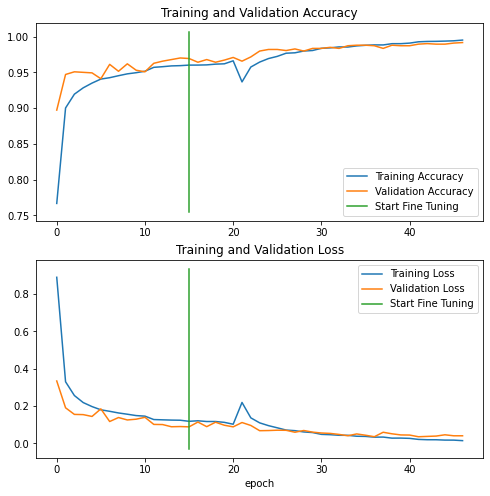

In [ ]:
compare_historys(history_1,history_2,initial_epochs = 16)

> *  Training accuracy - 98.96%
> *  Testing Accuracy - 98%
> *  Validation Accuracy - 97.8%

In [ ]:
def plot_training(model):
    # Lấy đối tượng history từ model

    #history_1 = model.history

    # Lấy giá trị từ history
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Tìm epoch có giá trị loss thấp nhất và accuracy cao nhất trên tập validation
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Tạo danh sách các epoch
    Epochs = [i+1 for i in range(len(tr_acc))]

    # Nhãn hiển thị cho epoch tốt nhất
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Vẽ lịch sử huấn luyện
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Vẽ biểu đồ loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ biểu đồ
plot_training(history_1)

NameError: name 'history' is not defined

> The results are pretty good now let us evaluate our model using other metrics such precision,recall and f1-score

# Model Evaluation

In [ ]:
pred_probs = model_1.predict(test_data)
pred_probs[0]

array([9.66390312e-01, 7.05760808e-13, 4.72401041e-07, 3.35888043e-02,
       3.89758131e-13, 7.62189103e-08, 2.14019319e-12, 1.12374124e-10,
       3.23607614e-16, 2.25709451e-09, 1.54476761e-11, 1.69659529e-11,
       7.73037009e-18, 5.29702931e-12, 1.43168338e-10, 1.30552619e-13,
       7.40293785e-07, 1.43384016e-13, 1.43384016e-13, 3.05282160e-14,
       1.44812721e-12, 7.58764405e-12, 1.86223327e-15, 2.00208943e-14,
       2.02508465e-16, 1.94499880e-05, 3.19932950e-14, 4.36638746e-11,
       6.90862905e-12, 4.54032506e-11, 2.92704438e-08, 2.34207764e-10,
       2.00328532e-10, 3.37206866e-15, 2.69005356e-11, 6.22831756e-13,
       1.16221404e-20, 7.18383686e-12], dtype=float32)

In [ ]:
pred_classes = pred_probs.argmax(axis = 1)
pred_classes[0]

0

In [ ]:
y_labels = []
for img,label in test_data.unbatch():
  y_labels.append(label.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
print(len(y_labels))
print(len(pred_classes))

5459
5459


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report\n",classification_report(y_labels,pred_classes))

Classification Report
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      1.00      0.99        63
           2       1.00      0.93      0.96        28
           3       0.96      0.99      0.98       165
           4       1.00      0.99      0.99       151
           5       1.00      0.98      0.99       106
           6       1.00      0.99      0.99        86
           7       0.80      0.79      0.80        52
           8       1.00      0.99      1.00       120
           9       0.88      0.92      0.90        99
          10       1.00      1.00      1.00       117
          11       1.00      0.99      1.00       118
          12       0.99      1.00      1.00       139
          13       1.00      1.00      1.00       109
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00       552
          16       0.99      1.00      1.00       231
    

In [ ]:
classification_dict = classification_report(y_labels,pred_classes,output_dict = True)
classification_dict

{'0': {'precision': 0.953125,
  'recall': 0.9682539682539683,
  'f1-score': 0.9606299212598425,
  'support': 63},
 '1': {'precision': 0.984375,
  'recall': 1.0,
  'f1-score': 0.9921259842519685,
  'support': 63},
 '2': {'precision': 1.0,
  'recall': 0.9285714285714286,
  'f1-score': 0.962962962962963,
  'support': 28},
 '3': {'precision': 0.9647058823529412,
  'recall': 0.9939393939393939,
  'f1-score': 0.9791044776119404,
  'support': 165},
 '4': {'precision': 1.0,
  'recall': 0.9867549668874173,
  'f1-score': 0.9933333333333334,
  'support': 151},
 '5': {'precision': 1.0,
  'recall': 0.9811320754716981,
  'f1-score': 0.9904761904761905,
  'support': 106},
 '6': {'precision': 1.0,
  'recall': 0.9883720930232558,
  'f1-score': 0.9941520467836257,
  'support': 86},
 '7': {'precision': 0.803921568627451,
  'recall': 0.7884615384615384,
  'f1-score': 0.7961165048543688,
  'support': 52},
 '8': {'precision': 1.0,
  'recall': 0.9916666666666667,
  'f1-score': 0.99581589958159,
  'support': 

In [ ]:
classification_f1_scores = {}

for k,v in classification_dict.items():
  if k == "accuracy":
    break
  else:
    classification_f1_scores[class_names[int(k)]] = v["f1-score"]
classification_f1_scores

{'Apple___Apple_scab': 0.9606299212598425,
 'Apple___Black_rot': 0.9921259842519685,
 'Apple___Cedar_apple_rust': 0.962962962962963,
 'Apple___healthy': 0.9791044776119404,
 'Blueberry___healthy': 0.9933333333333334,
 'Cherry_(including_sour)___Powdery_mildew': 0.9904761904761905,
 'Cherry_(including_sour)___healthy': 0.9941520467836257,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0.7961165048543688,
 'Corn_(maize)___Common_rust_': 0.99581589958159,
 'Corn_(maize)___Northern_Leaf_Blight': 0.9009900990099011,
 'Corn_(maize)___healthy': 1.0,
 'Grape___Black_rot': 0.9957446808510638,
 'Grape___Esca_(Black_Measles)': 0.996415770609319,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1.0,
 'Grape___healthy': 1.0,
 'Orange___Haunglongbing_(Citrus_greening)': 0.9981884057971014,
 'Peach___Bacterial_spot': 0.9956896551724138,
 'Peach___healthy': 0.9859154929577464,
 'Pepper,_bell___Bacterial_spot': 1.0,
 'Pepper,_bell___healthy': 0.9966555183946488,
 'Potato___Early_blight': 0.995024

In [ ]:
f1_scores = pd.DataFrame({"class_name":list(classification_f1_scores.keys()),
                          "F1_Score": list(classification_f1_scores.values())})

f1_scores.sort_values("F1_Score",ascending = False)

,class_name,F1_Score
14,Grape___healthy,1.000000
10,Corn_(maize)___healthy,1.000000
23,Raspberry___healthy,1.000000
18,"Pepper,_bell___Bacterial_spot",1.000000
13,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),1.000000
27,Strawberry___healthy,1.000000
15,Orange___Haunglongbing_(Citrus_greening),0.998188
25,Squash___Powdery_mildew,0.997290
19,"Pepper,_bell___healthy",0.996656
12,Grape___Esca_(Black_Measles),0.996416


> From the F1-Scores dataframe we can clearly see that our model perform best in identifying Corn(maize) rust with an perfect F1-Score of 1.00 and perform the worst in identifying Corn(maize) Grey leaf with an F1-Score of 0.80 which is also not bad when compared to normal standards.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

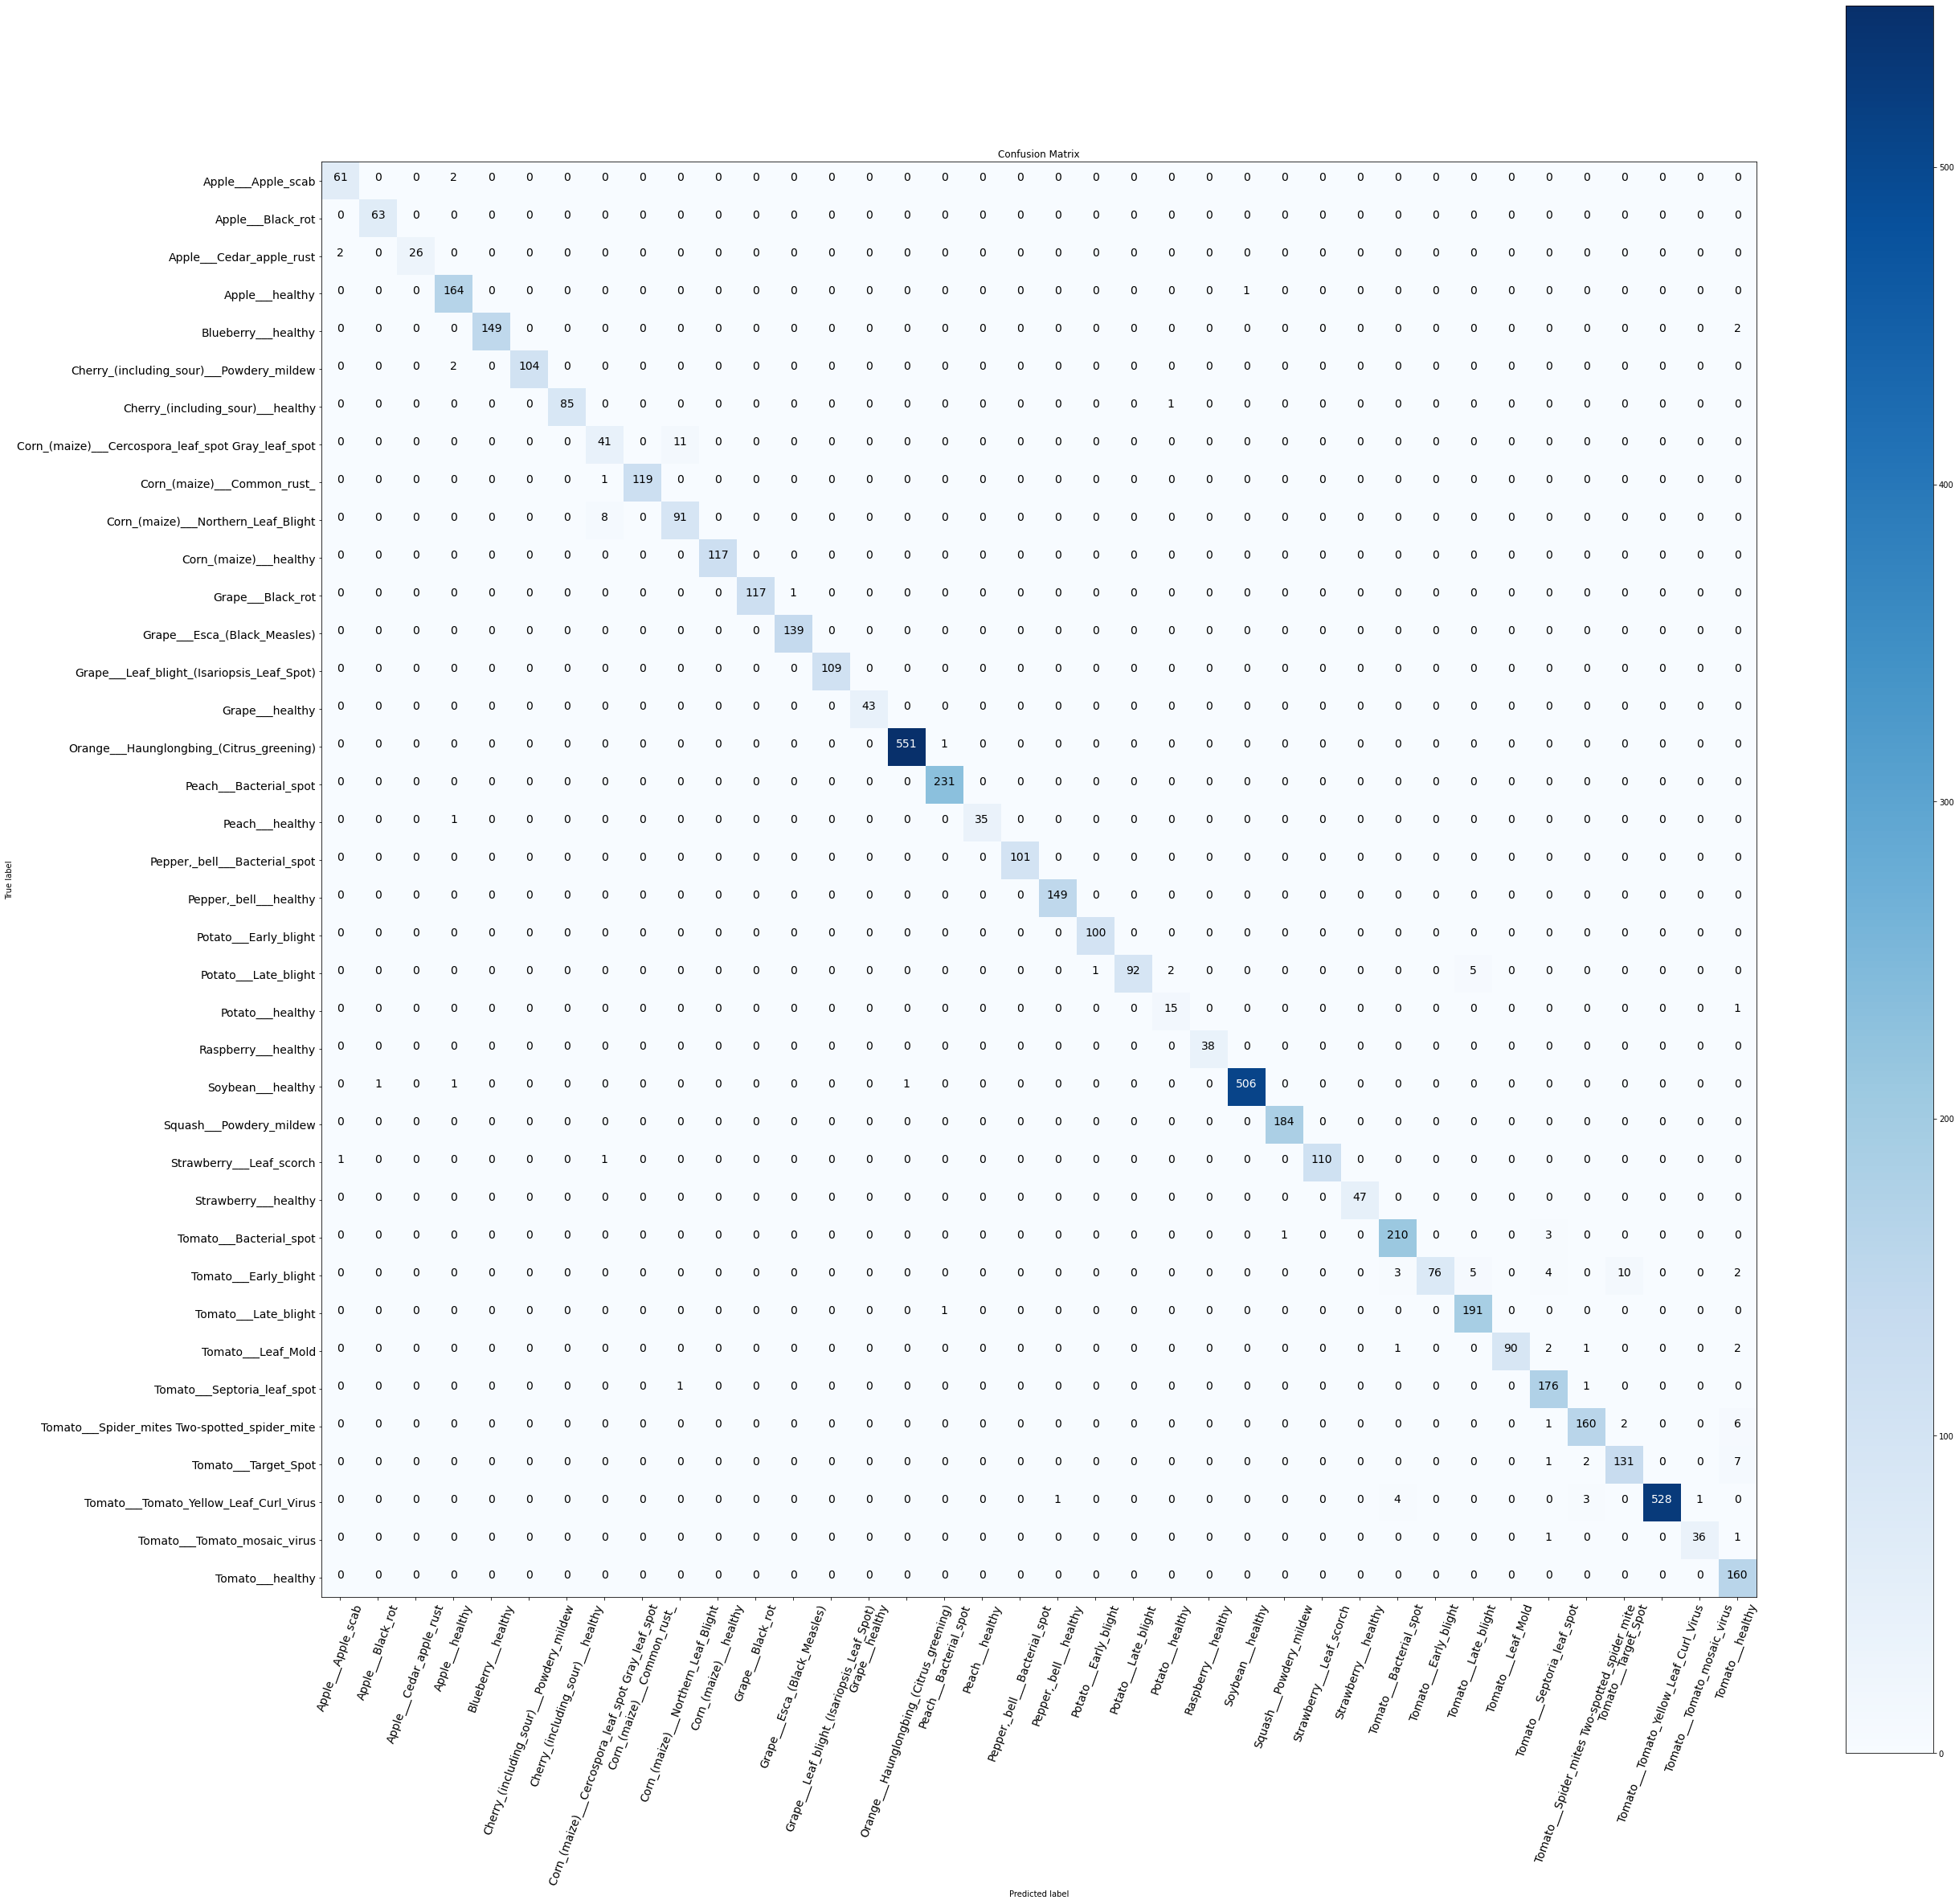

In [ ]:
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (40,40),text_size = 14)

>  From the confusion matrix(when zoomed) it clear that our model is getting confused between Tomato Early Blight and Tomato Spider mites, Tomato Early Blight and Tomato Target Spot.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the train data directory
train_dir = 'output/train'

# Define the image data generator for the train data
train_data_generator = ImageDataGenerator(
    rescale=1./255, # normalize pixel values to [0,1]
    shear_range=0.2, # apply shear transformation
    zoom_range=0.2, # apply zoom transformation
    horizontal_flip=True # flip images horizontally
)

# Define the batch size for the train data
batch_size = 32

# Prepare the train data generator
train_data = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize images to (224, 224)
    batch_size=batch_size,
    class_mode='categorical', # classify images into multiple classes
    shuffle=True # shuffle the data
)


Found 43429 images belonging to 38 classes.


In [ ]:
val_data = ImageDataGenerator().flow_from_directory(
    directory='output/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 5417 images belonging to 38 classes.


In [ ]:
from PIL import Image
import os

train_dir = 'output/train'
image_size = set()

for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    for image_file in os.listdir(folder_path):
        image = Image.open(os.path.join(folder_path, image_file))
        image_size.add(image.size)
print(image_size)

{(256, 256)}


In [ ]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Specify the number of categories
num_classes = 38

#Build DenseNet169 model
densenet_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new Sequential model and add layers
model = Sequential()
model.add(densenet_model)
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Freeze DenseNet169 layers
for layer in densenet_model.layers:
    layer.trainable = False

# Initialize the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Save the model
model.save('best_model.h5')


# Thank You